# MFN: Compare Different Sweeprates (SR830 vs. SR785)

In [1]:
%run test/basics.py

%matplotlib inline
import os
os.chdir('../../ana')

# IPython Interactions
import ipywidgets as wg
from IPython.display import display

## Define Functions

In [2]:
def load_data(datapath):
    meas_data = {}
    meas_info = {}
    all_data = {}
    for f in datapath:
        f_info = ana.measurement.MeasurementClass().get_info_from_name(f)
        sr = f_info['SR']
        nr = f_info['nr']
        meas_info[sr] = f_info
        meas_data[sr] = pd.read_csv(f, sep='\t')
        new_df = meas_data[sr]
        new_df['Vin'] = float(sr)
        if nr in all_data.keys():
            all_data[nr] = pd.concat([all_data[nr], new_df])
        else:
            all_data[nr] = new_df
    return meas_data, meas_info, all_data


### Calc PSD

In [3]:
def calc_PSD(meas_data):
    meas_obj = {}
    for sr, data_df in meas_data.items():
        if len(data_df['Vx']) % 1024:
            avg = len(data_df['Vx']) // 1024
            d = data_df['Vx'].iloc[:-(len(data_df['Vx']) % 1024)]
        else:
            d = data_df.Vx

        max_len = len(d)

        data = {
                    'data': d,
                    'info': {
                        'Nr': meas_info[sr]['nr'],
                        'rate': 1 / data_df.time.diff().mean(),
                        'length': max_len * data_df.time.diff().mean(),
                    }
                }

        meas_obj[sr] = ana.RAW(data,
                             rate=data['info']['rate'],
                             nof_first_spectra=32,
                             calc_first = True,
                             downsample=False,
                             )
    return meas_obj

### Plotting functions

In [4]:
#%matplotlib inline
import scipy.stats

def merge_data(meas_obj, cutoff_frequency=.9):
    diff_voltages = pd.DataFrame()
    for sr, m in meas_obj.items():
        s = m.avg_spec
        s = s[s.freq < cutoff_frequency]
        if len(s) < 2:
            continue
        newdf = pd.DataFrame()
        newdf['freq'] = s.freq
        newdf['S'] = s.S
        newdf['SR'] = float(sr)
        diff_voltages = pd.concat([diff_voltages, newdf])
    return diff_voltages


def plot_PSD_classic(diff_voltages, title, groupby_category='SR', group_name='Sweep Rate',
                     num=10, style=[['science'], {'context': 'talk', 'style': 'white', 'palette': 'bright',}]):
    set_style(style)
    c1 = sns.color_palette("hls", num)
    sns.set_palette(c1)
    fig, ax = plt.subplots(figsize=(16,12))
    grouped  = diff_voltages.groupby(groupby_category)
    for group in grouped.groups.keys():
        grouped.get_group(group).plot(x='freq', y='S', kind='line', 
                                      loglog=True, ax=ax, 
                                      label='%d %s' % (group, group_name),
                                      xlabel='Frequency [Hz]',
                                      ylabel='$S_{V_H}$ [$\\mathrm{V}^2/\\mathrm{Hz}$]',
                                     )
    ax.set_title(title)
    return ax
f_max = (8/(2*np.pi))


### Contour Plot

In [5]:
from matplotlib import cm
from matplotlib.colors import LogNorm

def plot_PSD_contour(meas_obj, diff_voltages, title,
                     cutoff_frequency=.9,
                     groupby_category='SR'):
    diff_voltages_contour = pd.DataFrame()
    for sr, m in meas_obj.items():
        s = m.avg_spec
        s = s[s.freq < cutoff_frequency]
        if len(s) < 2:
            continue
        diff_voltages_contour[float(sr[:-2])] = s.S

    v = diff_voltages[groupby_category].unique()
    v.sort()
    frequencies = diff_voltages.freq.unique()
    smin, smax = diff_voltages.S.min(), diff_voltages.S.max()
    levels = np.logspace(np.log10(smin),
                         np.log10(smax), 10)

    fig, ax = plt.subplots(figsize=(12,8))
    cs = ax.contourf(v, frequencies, diff_voltages_contour,
                     norm=LogNorm(vmin=smin, vmax=smax),
                     levels=levels,
                     cmap=plt.cm.Blues,
                     )
    cbar = plt.gcf().colorbar(cs, ax=ax)
    cbar.set_label('$S_V^{SR} (f)$')
    cbar.set_ticklabels(['%.1e' % _ for _ in levels])
    ax.set_yscale('log')
    ax.set_ylabel('$f$ [Hz]')
    ax.set_xlabel('Sweeprate [$\\mathrm{mT}/\\mathrm{min}$]')
    ax.set_title(title)

#plot_PSD_contour(meas_obj, diff_voltages, 'm506: Different Voltages ($\\tau = 100~\\mathrm{ms}$; $f_{Ref} = 17~\\mathrm{Hz}$)')

## Load Data

### m497

In [6]:
datapath = glob('./data/MFN/m497/*')
datapath

meas_data, meas_info, all_data = load_data(datapath)

In [7]:
meas_obj = calc_PSD(meas_data)
meas_obj.items()

dict_items([('0.015', RAW (Nr. 497)
), ('0.0025', RAW (Nr. 497)
), ('0.005', RAW (Nr. 497)
), ('0.010', RAW (Nr. 497)
), ('0.0015', RAW (Nr. 497)
), ('0.020', RAW (Nr. 497)
)])

## Plot PSD

In [8]:
%matplotlib inline

### Classic

In [9]:
meas_obj

{'0.015': RAW (Nr. 497),
 '0.0025': RAW (Nr. 497),
 '0.005': RAW (Nr. 497),
 '0.010': RAW (Nr. 497),
 '0.0015': RAW (Nr. 497),
 '0.020': RAW (Nr. 497)}

<AxesSubplot:title={'center':'m497: Different Sweeprates ($\\tau = 3~\\mathrm{ms}$; $f_{Ref} = 17~\\mathrm{Hz}$)'}, xlabel='Frequency [Hz]', ylabel='$S_{V_H}$ [$\\mathrm{V}^2/\\mathrm{Hz}$]'>

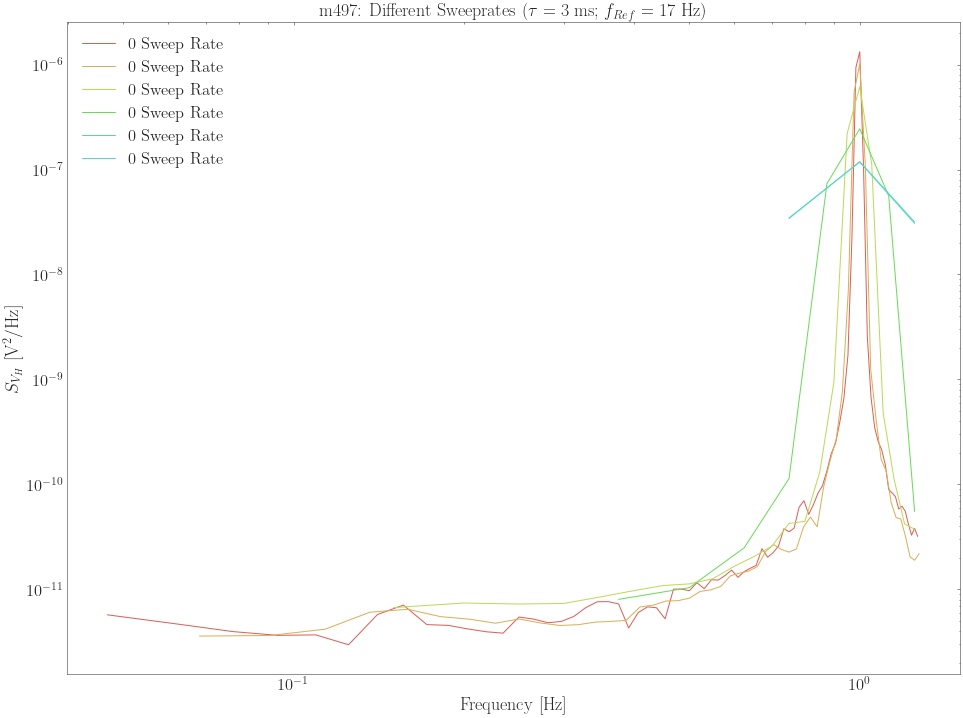

In [10]:
diff_voltages = merge_data(meas_obj, cutoff_frequency=f_max)
plot_PSD_classic(diff_voltages, 'm497: Different Sweeprates ($\\tau = 3~\\mathrm{ms}$; $f_{Ref} = 17~\\mathrm{Hz}$)')

### Contour

## Load m500

In [11]:
datapath = glob('./data/MFN/m500/*')
meas_data, meas_info, all_data = load_data(datapath)
meas_obj = calc_PSD(meas_data)
meas_obj.items()

dict_items([('0.020', RAW (Nr. 500)
), ('0.0025', RAW (Nr. 500)
), ('0.010', RAW (Nr. 500)
), ('0.005', RAW (Nr. 500)
), ('0.015', RAW (Nr. 500)
), ('0.0010', RAW (Nr. 500)
)])

<AxesSubplot:title={'center':'m500: Sweeprates ($\\tau = 3~\\mathrm{ms}$; $f_{Ref} = 113~\\mathrm{Hz}$)'}, xlabel='Frequency [Hz]', ylabel='$S_{V_H}$ [$\\mathrm{V}^2/\\mathrm{Hz}$]'>

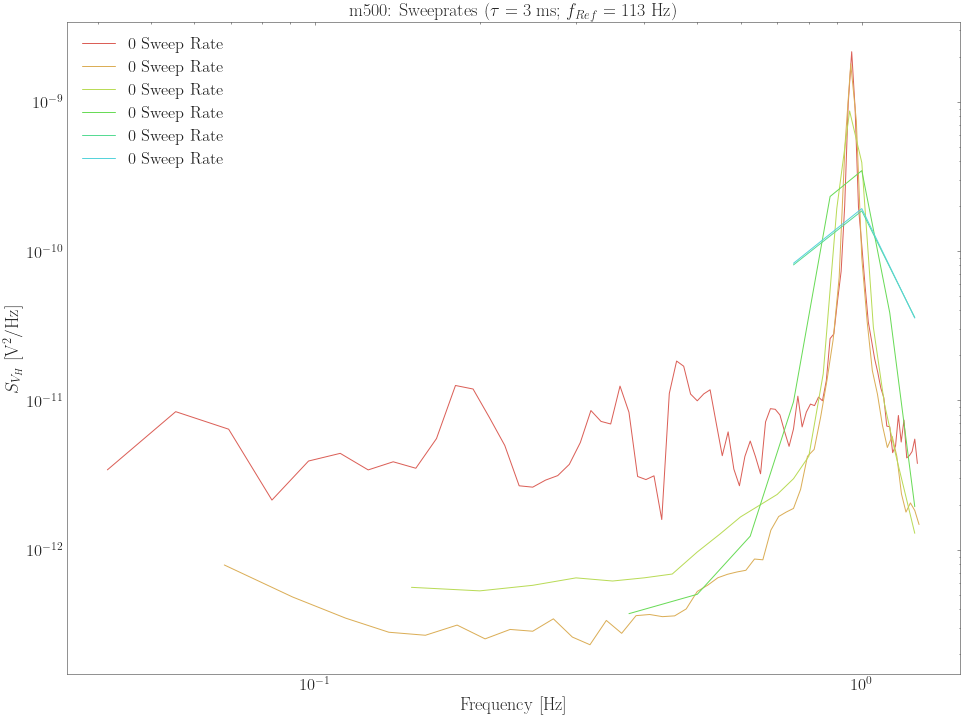

In [12]:
diff_voltages = merge_data(meas_obj, cutoff_frequency=f_max)
plot_PSD_classic(diff_voltages, 'm500: Sweeprates ($\\tau = 3~\\mathrm{ms}$; $f_{Ref} = 113~\\mathrm{Hz}$)')

In [13]:
# plot_PSD_contour(meas_obj, diff_voltages, 'm499: Different Voltages ($\\tau = 3~\\mathrm{ms}$; $f_{Ref} = 113~\\mathrm{Hz}$)')

## m501

In [14]:
meas_obj.items()

dict_items([('0.020', RAW (Nr. 500)
), ('0.0025', RAW (Nr. 500)
), ('0.010', RAW (Nr. 500)
), ('0.005', RAW (Nr. 500)
), ('0.015', RAW (Nr. 500)
), ('0.0010', RAW (Nr. 500)
)])

In [15]:
datapath = glob('./data/MFN/m501/*')
meas_data, meas_info, all_data = load_data(datapath)
meas_obj = calc_PSD(meas_data)
diff_voltages = merge_data(meas_obj, cutoff_frequency=f_max)
title = 'm501: Different Sweeprates ($\\tau = 3~\\mathrm{ms}$; $f_{Ref} = 113~\\mathrm{Hz}$)'
#plot_PSD_classic(diff_voltages, title)
meas_obj

{'0.0020': RAW (Nr. 501),
 '0': RAW (Nr. 501),
 '0.0015': RAW (Nr. 501),
 '0.0005': RAW (Nr. 501),
 '0.0010': RAW (Nr. 501)}

<AxesSubplot:xlabel='t'>

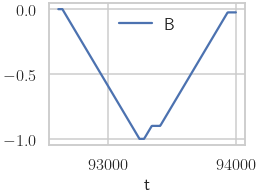

In [16]:
df = pd.read_csv('./data/MFN/Test_measurements/m501.91_Temp_during_meas.dat', sep='\t', skiprows=3, names=['t', 'B'] + ['T%d' % _ for _ in range(6)])
df['dB'] = df.B.diff()
df[df.t < 9.4e4].plot(x='t', y='B')

## m502

<AxesSubplot:title={'center':'m502: Different Sweeprates ($\\tau = 30~\\mathrm{ms}$; $f_{Ref} = 113~\\mathrm{Hz}$)'}, xlabel='Frequency [Hz]', ylabel='$S_{V_H}$ [$\\mathrm{V}^2/\\mathrm{Hz}$]'>

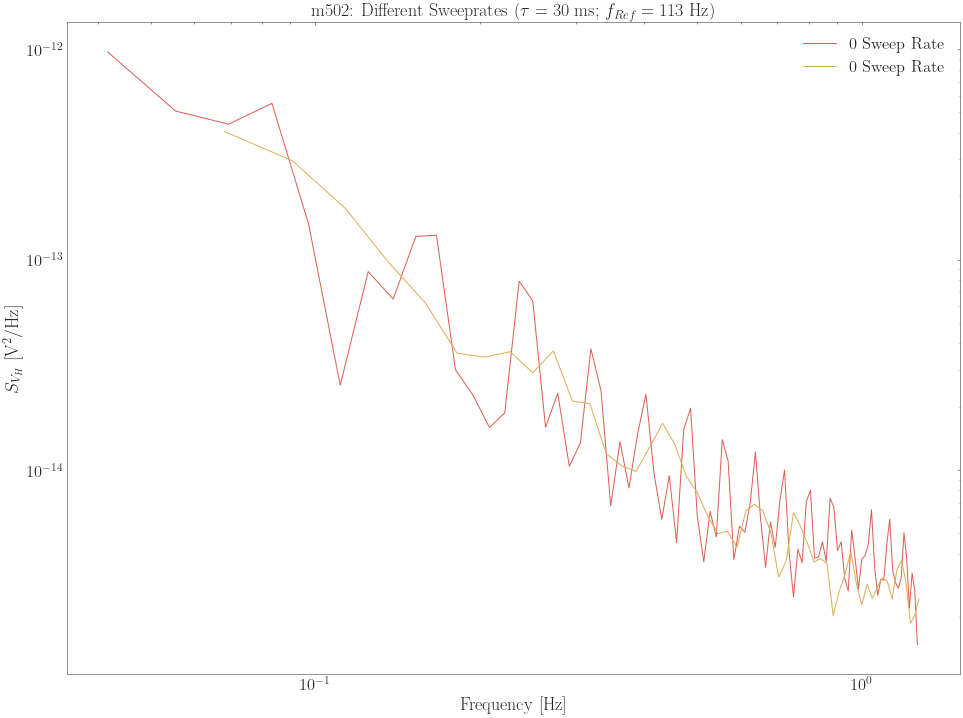

In [17]:
datapath = glob('./data/MFN/m502/*')
meas_data, meas_info, all_data = load_data(datapath)
meas_obj = calc_PSD(meas_data)
diff_voltages = merge_data(meas_obj, cutoff_frequency=f_max)
title = 'm502: Different Sweeprates ($\\tau = 30~\\mathrm{ms}$; $f_{Ref} = 113~\\mathrm{Hz}$)'
plot_PSD_classic(diff_voltages, title)

## m507

In [18]:
glob('./data/MFN/m507/*')

['./data/MFN/m507/m507_Plusses_90deg_RAW_Parallel_B_pm25mT_SR-0.0010_20200816_1000_I2-13-1_GBIP8-14-7_Vin-5V_R21-1MO_C21-11_T-15K_gate-0V.dat',
 './data/MFN/m507/m507_Plusses_90deg_RAW_Parallel_B_pm25mT_SR-0.0015_20200816_1000_I2-13-1_GBIP8-14-7_Vin-5V_R21-1MO_C21-11_T-15K_gate-0V.dat',
 './data/MFN/m507/m507_Plusses_90deg_RAW_Parallel_B_pm25mT_SR-0.0_20200816_1000_I2-13-1_GBIP8-14-7_Vin-5V_R21-1MO_C21-11_T-15K_gate-0V.dat',
 './data/MFN/m507/m507_Plusses_90deg_RAW_Parallel_B_pm25mT_SR-0.0020_20200816_1000_I2-13-1_GBIP8-14-7_Vin-5V_R21-1MO_C21-11_T-15K_gate-0V.dat']

/var/folders/nm/0s3x_nnn1ss1n7rd1px5gqsr0000gn/T/ipykernel_34002/89367565.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fit_area['lnf'] = np.log10(fit_area.freq)
/var/folders/nm/0s3x_nnn1ss1n7rd1px5gqsr0000gn/T/ipykernel_34002/89367565.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fit_area['lnS'] = np.log10(fit_area.S)


Text(0, 0.5, '$\\alpha$')

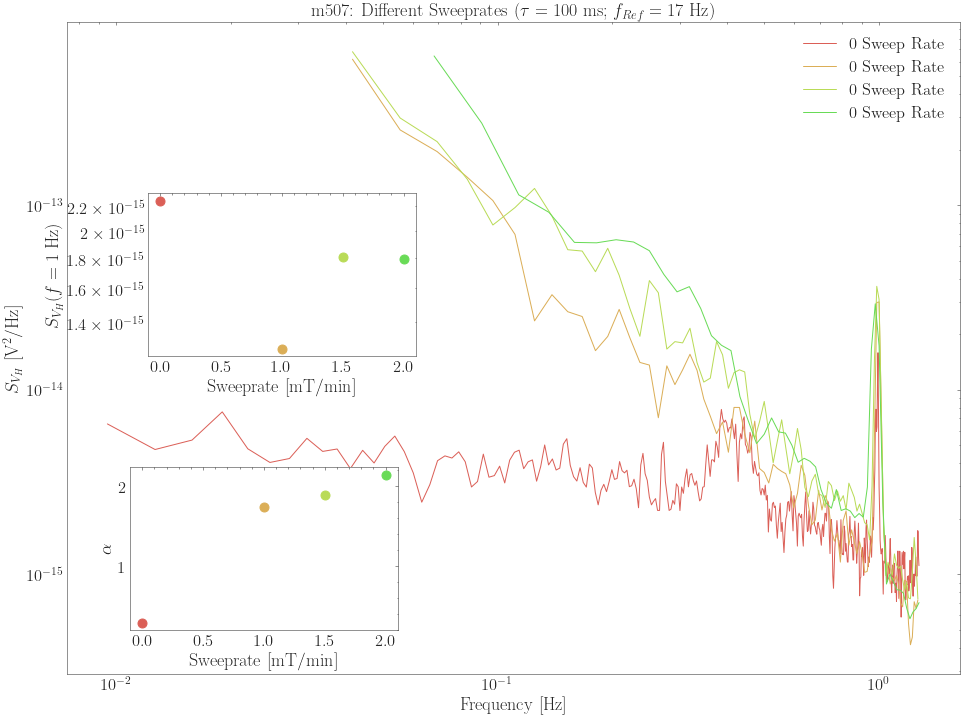

In [19]:
datapath = glob('./data/MFN/m507/*')
meas_data, meas_info, all_data = load_data(datapath)
meas_obj = calc_PSD(meas_data)
diff_voltages = merge_data(meas_obj, cutoff_frequency=f_max)
title = 'm507: Different Sweeprates ($\\tau = 100~\\mathrm{ms}$; $f_{Ref} = 17~\\mathrm{Hz}$)'
ax = plot_PSD_classic(diff_voltages, title)

inset2 = inset_axes(ax, width='100%', height='100%', 
                   bbox_to_anchor=(.1, .5, .3, .25),
                   bbox_transform=ax.transAxes)
inset3 = inset_axes(ax, width='100%', height='100%', 
                   bbox_to_anchor=(.08, .08, .3, .25),
                   bbox_transform=ax.transAxes)

grouped = diff_voltages.groupby('SR')
for group in grouped.groups.keys():
    g = grouped.get_group(group)
    fit_area = g.query('freq > %f and freq < %f' % (8e-2, 7e-1))
    fit_area['lnf'] = np.log10(fit_area.freq)
    fit_area['lnS'] = np.log10(fit_area.S)
    fit = scipy.stats.linregress(fit_area.lnf, fit_area.lnS)
    intercept, slope = fit.intercept, -fit.slope
    voltage = group*1e3

    inset2.plot(voltage, 10**intercept, 'o')
    inset3.plot(voltage, slope, 'o')

inset2.set_xlabel('Sweeprate [$\\mathrm{mT}/\\mathrm{min}$]')
inset2.set_ylabel('$S_{V_H} (f=1\\;$Hz$)$')
inset2.set_yscale('log')

inset3.set_xlabel('Sweeprate [$\\mathrm{mT}/\\mathrm{min}$]')
inset3.set_ylabel('$\\alpha$')


## Sweeprates SR785

In [20]:
m = ana.Hloop(57)
eva = ana.HandleM(directory='data/SR785')

/Users/jp/Projects/Code/method-paper/ana/ana/handle.py:103: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  self.load_folder(file_list, **kwargs)


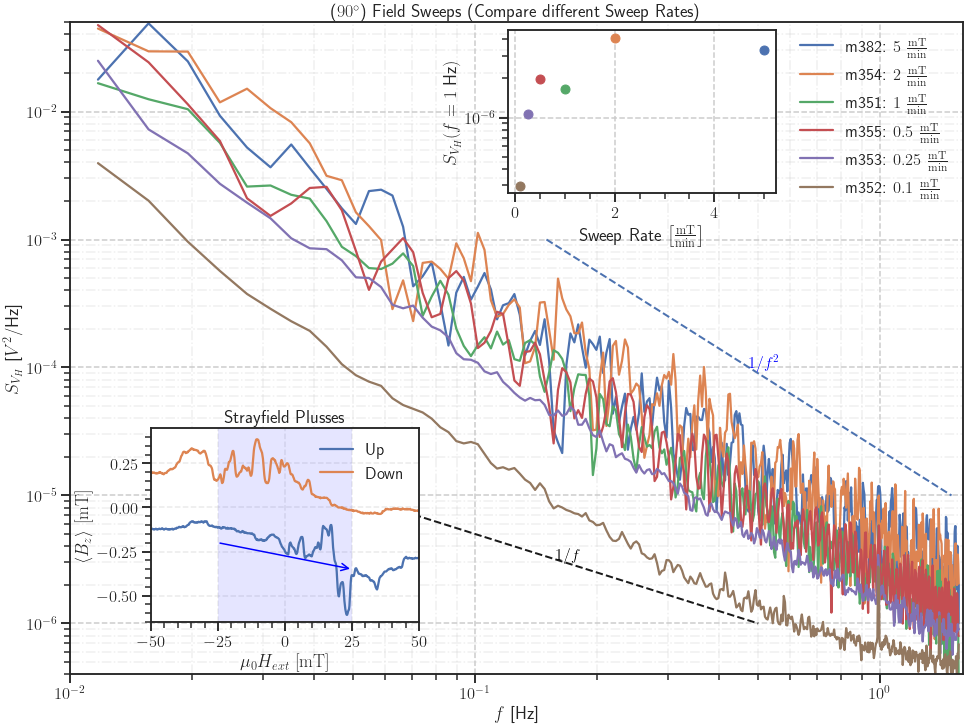

In [21]:
eva.style.set_style(default=True, grid=True, 
                 size='talk', style='ticks', latex=True,
                 palette='deep')


lofm = {}
to_show = {
    382: [("-M_s \\rightarrow -25",25), 'Plusses', 5],
    354: [("-M_s \\rightarrow -25",25), 'Plusses', 2],
    351: [("-M_s \\rightarrow -25",25), 'Plusses', 1],
    355: [("-M_s \\rightarrow -25",25), 'Plusses', .5],
    353: [("-M_s \\rightarrow -25",25), 'Plusses', .25],
    352: [("-M_s \\rightarrow -25",25), 'Plusses', .1],
}

for nr, content in to_show.items():
    lofm[nr] = ["$%s\\;\\frac{\\mathrm{mT}}{\\mathrm{min}}$" % (
                content[2],
                ),{}]

fig, ax = eva.plot(lofm,
       #fit_range=(2e-2, 5e-1),
       #show_fit=True,
         plot_settings=dict(
             title='($90^\\circ$) Field Sweeps (Compare different Sweep Rates)',
             xlim=(1e-2, 1.6e0),
             ylim=(4e-7, 5e-2)),
         f_settings=dict(
             xmin=5e-2,
             ymin=1e-5),
         f2_settings=dict(
             xmin=1.5e-1,
             ),
         )

ax = plt.gca()
# Inset with Strayfield
with sns.color_palette('deep'):
    inset = inset_axes(ax, width='100%', height='90%', 
                       bbox_to_anchor=(.1, .06, .3, .33),
                       bbox_transform=ax.transAxes)
    m.plot_strayfield(inset, 'Strayfield Plusses', 
                      nolegend=True,)
    inset.legend(['Up',# ($-M_S \\rightarrow +M_S$)', 
                  'Down'])# ($+M_S \\rightarrow -M_S$)'])
    inset.grid(b=True, alpha=.4)
    inset.set_xlim(-50, 50)
    inset.set_ylim(-.65, .45)
    inset.set_xticks([-50+25*_ for _ in range(5)])

    y1, y2 = -1, 2
    inset.fill([-25, -25, 25, 25], [y1, y2, y2, y1], 'blue', alpha=.1)
    inset.annotate("", xy=(25, -.35), xytext=(-25, -.2),
                 arrowprops=dict(arrowstyle="->", color='blue'))


# Inset showing fitted data
with sns.color_palette("deep"):
    inset2 = inset_axes(ax, width='100%', height='100%', 
                       bbox_to_anchor=(.5, .75, .3, .25),
                       bbox_transform=ax.transAxes)

    for nr, content in to_show.items():
        intercept, slope = eva[nr].fit(fit_range=(2e-2, 5e-1))
        sweep_rate = content[2]

        inset2.plot(sweep_rate, 10**intercept, 'o')

    inset2.set_xlabel('Sweep Rate $\\left[\\frac{\\mathrm{mT}}{\\mathrm{min}}\\right]$')
    inset2.set_ylabel('$S_{V_H} (f=1\\;$Hz$)$')
    inset2.set_yscale('log')
